<a href="https://colab.research.google.com/github/mdsiam135/research/blob/main/HistGradientBoostingClassifier(3_labels).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
# ============================================================================
# STEP-BY-STEP HISTGRADIENTBOOSTINGCLASSIFIER FOR AGRICULTURAL PRODUCTION
# ============================================================================

# Step 1: Import Required Libraries
# ============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                           f1_score, confusion_matrix, classification_report)
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")
np.random.seed(42)

print("Step 1: Libraries imported successfully!")


Step 1: Libraries imported successfully!


In [10]:

# Step 2: Load and Explore the Datasets
# ============================================================================
def load_datasets():
    """Load the three CSV files and explore basic information"""
    print("\nStep 2: Loading datasets...")

    # Load datasets
    try:
        train_df = pd.read_csv('/content/drive/MyDrive/Yearbook of Agricultural Statistics/train.csv')
        val_df = pd.read_csv('/content/drive/MyDrive/Yearbook of Agricultural Statistics/validation.csv')
        test_df = pd.read_csv('/content/drive/MyDrive/Yearbook of Agricultural Statistics/test.csv')

        print(f"✓ Training data shape: {train_df.shape}")
        print(f"✓ Validation data shape: {val_df.shape}")
        print(f"✓ Test data shape: {test_df.shape}")

        # Display basic info
        print(f"\nDataset Overview:")
        print(f"Total features: {len(train_df.columns) - 1}")  # -1 for target column
        print(f"Target column: Production (M.Ton)")

        # Check for missing values
        print(f"\nMissing values in training data: {train_df.isnull().sum().sum()}")
        print(f"Missing values in validation data: {val_df.isnull().sum().sum()}")
        print(f"Missing values in test data: {test_df.isnull().sum().sum()}")

        return train_df, val_df, test_df

    except FileNotFoundError as e:
        print(f"❌ Error: CSV files not found. Please ensure files exist:")
        print("- train.csv")
        print("- validation.csv")
        print("- test.csv")
        raise e


In [11]:

# Step 3: Create Target Labels Based on Quantiles
# ============================================================================
def create_target_labels(train_df, val_df, test_df):
    """Create low, medium, high labels based on production quantiles"""
    print("\nStep 3: Creating target labels...")

    production_col = 'Production (M.Ton)'

    # Calculate quantiles from training data only
    q33 = train_df[production_col].quantile(0.33)
    q67 = train_df[production_col].quantile(0.67)

    print(f"Quantile boundaries:")
    print(f"- Low: <= {q33:.2f} M.Ton")
    print(f"- Medium: {q33:.2f} - {q67:.2f} M.Ton")
    print(f"- High: > {q67:.2f} M.Ton")

    def categorize_production(production_value):
        if production_value <= q33:
            return 'low'
        elif production_value <= q67:
            return 'medium'
        else:
            return 'high'

    # Create labels for all datasets
    train_labels = train_df[production_col].apply(categorize_production)
    val_labels = val_df[production_col].apply(categorize_production)
    test_labels = test_df[production_col].apply(categorize_production)

    # Display label distribution
    print(f"\nLabel distribution:")
    print("Training set:")
    print(train_labels.value_counts().sort_index())
    print("Validation set:")
    print(val_labels.value_counts().sort_index())
    print("Test set:")
    print(test_labels.value_counts().sort_index())

    return train_labels, val_labels, test_labels, (q33, q67)


In [12]:

# Step 4: Prepare Features (Remove Target Column and Handle Missing Values)
# ============================================================================
def prepare_features(train_df, val_df, test_df):
    """Prepare feature matrices by removing target and handling missing values"""
    print("\nStep 4: Preparing features...")

    # Remove target column to get features
    target_col = 'Production (M.Ton)'
    X_train = train_df.drop(columns=[target_col])
    X_val = val_df.drop(columns=[target_col])
    X_test = test_df.drop(columns=[target_col])

    print(f"Features extracted: {X_train.shape[1]} columns")

    # Handle missing values - fill with training set mean
    print("Handling missing values...")
    train_means = X_train.mean()

    X_train_filled = X_train.fillna(train_means)
    X_val_filled = X_val.fillna(train_means)  # Use train means
    X_test_filled = X_test.fillna(train_means)  # Use train means

    print(f"✓ Missing values handled")
    print(f"✓ Feature columns: {list(X_train_filled.columns[:5])}... (showing first 5)")

    return X_train_filled, X_val_filled, X_test_filled, list(X_train_filled.columns)


In [13]:

# Step 5: Scale Features and Encode Labels
# ============================================================================
def scale_and_encode(X_train, X_val, X_test, y_train, y_val, y_test):
    """Scale features and encode string labels to numbers"""
    print("\nStep 5: Scaling features and encoding labels...")

    # Initialize scalers and encoders
    scaler = StandardScaler()
    label_encoder = LabelEncoder()

    # Scale features
    print("Scaling features...")
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    # Encode labels (low=0, medium=1, high=2)
    print("Encoding labels...")
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_val_encoded = label_encoder.transform(y_val)
    y_test_encoded = label_encoder.transform(y_test)

    print(f"✓ Features scaled to mean=0, std=1")
    print(f"✓ Labels encoded: {dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))}")

    return (X_train_scaled, X_val_scaled, X_test_scaled,
            y_train_encoded, y_val_encoded, y_test_encoded,
            scaler, label_encoder)


In [14]:

# Step 6: Initialize and Configure the Model
# ============================================================================
def initialize_model():
    """Initialize HistGradientBoostingClassifier with optimal parameters"""
    print("\nStep 6: Initializing HistGradientBoostingClassifier...")

    model = HistGradientBoostingClassifier(
        max_iter=100,              # Maximum number of boosting iterations
        learning_rate=0.1,         # Learning rate (step size)
        max_depth=6,               # Maximum depth of trees
        min_samples_leaf=20,       # Minimum samples in leaf nodes
        l2_regularization=0.1,     # L2 regularization strength
        early_stopping=True,       # Enable early stopping
        validation_fraction=0.1,   # Fraction for early stopping validation
        n_iter_no_change=5,        # Iterations without improvement to stop
        random_state=42           # For reproducibility
    )

    print("✓ Model initialized with parameters:")
    print(f"  - Max iterations: 100")
    print(f"  - Learning rate: 0.1")
    print(f"  - Max depth: 6")
    print(f"  - Early stopping: Enabled")

    return model


In [15]:

# Step 7: Train Model with Epoch Tracking
# ============================================================================
def train_with_epoch_tracking(X_train, X_val, y_train, y_val, max_epochs=100):
    """Train model and track performance over epochs"""
    print(f"\nStep 7: Training model with epoch tracking...")

    # Create epoch ranges for tracking
    epoch_range = list(range(10, max_epochs + 1, 10))
    train_accuracies = []
    val_accuracies = []

    print("Training progress:")
    print("Epoch | Train Acc | Val Acc")
    print("-" * 30)

    # Train models with different iteration counts to simulate epochs
    for n_iter in epoch_range:
        # Create temporary model for this "epoch"
        temp_model = HistGradientBoostingClassifier(
            max_iter=n_iter,
            learning_rate=0.1,
            max_depth=6,
            min_samples_leaf=20,
            l2_regularization=0.1,
            random_state=42
        )

        # Train model
        temp_model.fit(X_train, y_train)

        # Get predictions
        train_pred = temp_model.predict(X_train)
        val_pred = temp_model.predict(X_val)

        # Calculate accuracies
        train_acc = accuracy_score(y_train, train_pred)
        val_acc = accuracy_score(y_val, val_pred)

        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        print(f"{n_iter:5d} | {train_acc:9.4f} | {val_acc:7.4f}")

    # Train final model with full epochs
    final_model = HistGradientBoostingClassifier(
        max_iter=max_epochs,
        learning_rate=0.1,
        max_depth=6,
        min_samples_leaf=20,
        l2_regularization=0.1,
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=5,
        random_state=42
    )

    print(f"\nTraining final model...")
    final_model.fit(X_train, y_train)
    print(f"✓ Final model trained successfully!")

    return final_model, epoch_range, train_accuracies, val_accuracies


In [16]:

# Step 8: Calculate All Classification Metrics
# ============================================================================
def calculate_metrics(model, X, y, dataset_name, label_encoder):
    """Calculate comprehensive classification metrics"""
    print(f"\nStep 8: Calculating metrics for {dataset_name}...")

    # Get predictions
    y_pred = model.predict(X)

    # Calculate all required metrics
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred, average='weighted')
    recall = recall_score(y, y_pred, average='weighted')
    f1_weighted = f1_score(y, y_pred, average='weighted')
    f1_macro = f1_score(y, y_pred, average='macro')

    # Get confusion matrix
    cm = confusion_matrix(y, y_pred)

    # Print results
    print(f"\n{dataset_name} Results:")
    print("-" * 40)
    print(f"Accuracy:           {accuracy:.4f}")
    print(f"Precision (Weighted): {precision:.4f}")
    print(f"Recall (Weighted):    {recall:.4f}")
    print(f"F1-Score (Weighted):  {f1_weighted:.4f}")
    print(f"Macro F1-Score:       {f1_macro:.4f}")

    # Detailed classification report
    class_names = label_encoder.classes_
    report = classification_report(y, y_pred, target_names=class_names)
    print(f"\nDetailed Classification Report:")
    print(report)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_weighted': f1_weighted,
        'f1_macro': f1_macro,
        'confusion_matrix': cm,
        'predictions': y_pred
    }


In [17]:

# Step 9: Plot Confusion Matrices
# ============================================================================
def plot_confusion_matrices(train_results, val_results, test_results, label_encoder):
    """Plot confusion matrices for all datasets"""
    print(f"\nStep 9: Plotting confusion matrices...")

    class_names = label_encoder.classes_

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Training confusion matrix
    sns.heatmap(train_results['confusion_matrix'], annot=True, fmt='d',
                cmap='Blues', xticklabels=class_names, yticklabels=class_names,
                ax=axes[0])
    axes[0].set_title('Training Set Confusion Matrix')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('Actual')

    # Validation confusion matrix
    sns.heatmap(val_results['confusion_matrix'], annot=True, fmt='d',
                cmap='Greens', xticklabels=class_names, yticklabels=class_names,
                ax=axes[1])
    axes[1].set_title('Validation Set Confusion Matrix')
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('Actual')

    # Test confusion matrix
    sns.heatmap(test_results['confusion_matrix'], annot=True, fmt='d',
                cmap='Oranges', xticklabels=class_names, yticklabels=class_names,
                ax=axes[2])
    axes[2].set_title('Test Set Confusion Matrix')
    axes[2].set_xlabel('Predicted')
    axes[2].set_ylabel('Actual')

    plt.tight_layout()
    plt.show()
    print("✓ Confusion matrices plotted successfully!")


In [18]:

# Step 10: Plot Training vs Validation Curves
# ============================================================================
def plot_training_curves(epochs, train_accs, val_accs):
    """Plot training and validation accuracy curves"""
    print(f"\nStep 10: Plotting training curves...")

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Accuracy curves
    ax1.plot(epochs, train_accs, 'b-', label='Training Accuracy', linewidth=2, marker='o')
    ax1.plot(epochs, val_accs, 'r-', label='Validation Accuracy', linewidth=2, marker='s')
    ax1.set_title('Model Accuracy Over Epochs')
    ax1.set_xlabel('Number of Iterations')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim([0.5, 1.0])

    # Difference between train and validation
    diff = [t - v for t, v in zip(train_accs, val_accs)]
    ax2.plot(epochs, diff, 'g-', label='Train - Validation Gap', linewidth=2, marker='^')
    ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax2.set_title('Overfitting Analysis')
    ax2.set_xlabel('Number of Iterations')
    ax2.set_ylabel('Accuracy Difference')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
    print("✓ Training curves plotted successfully!")


In [19]:

# Step 11: Create Results Summary Table
# ============================================================================
def create_summary_table(train_results, val_results, test_results):
    """Create comprehensive results summary table"""
    print(f"\nStep 11: Creating results summary table...")

    # Create summary DataFrame
    summary_data = {
        'Metric': ['Accuracy', 'Precision (Weighted)', 'Recall (Weighted)',
                  'F1-Score (Weighted)', 'Macro F1-Score'],
        'Training': [train_results['accuracy'], train_results['precision'],
                    train_results['recall'], train_results['f1_weighted'],
                    train_results['f1_macro']],
        'Validation': [val_results['accuracy'], val_results['precision'],
                      val_results['recall'], val_results['f1_weighted'],
                      val_results['f1_macro']],
        'Test': [test_results['accuracy'], test_results['precision'],
                test_results['recall'], test_results['f1_weighted'],
                test_results['f1_macro']]
    }

    summary_df = pd.DataFrame(summary_data)

    print("\n" + "="*70)
    print("FINAL RESULTS SUMMARY")
    print("="*70)
    print(summary_df.round(4).to_string(index=False))

    # Highlight best performances
    print(f"\n🏆 BEST PERFORMANCES:")
    print(f"Best Test Accuracy: {test_results['accuracy']:.4f}")
    print(f"Best Test Macro F1: {test_results['f1_macro']:.4f}")

    return summary_df


In [20]:

# Step 12: Feature Importance Analysis
# ============================================================================
def analyze_feature_importance(model, feature_names):
    """Analyze and plot feature importance"""
    print(f"\nStep 12: Analyzing feature importance...")

    if hasattr(model, 'feature_importances_'):
        # Create feature importance DataFrame
        importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': model.feature_importances_
        }).sort_values('Importance', ascending=False)

        print(f"\nTop 15 Most Important Features:")
        print("-" * 50)
        for i, (_, row) in enumerate(importance_df.head(15).iterrows(), 1):
            print(f"{i:2d}. {row['Feature']:<30} {row['Importance']:.4f}")

        # Plot top 20 features
        plt.figure(figsize=(12, 8))
        top_20 = importance_df.head(20)
        plt.barh(range(len(top_20)), top_20['Importance'])
        plt.yticks(range(len(top_20)), top_20['Feature'])
        plt.xlabel('Feature Importance')
        plt.title('Top 20 Most Important Features')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()

        print("✓ Feature importance analysis completed!")
        return importance_df
    else:
        print("❌ Model doesn't support feature importance")
        return None


In [21]:

# Step 13: Main Execution Function
# ============================================================================
def main():
    """Main function to execute all steps"""
    print("="*80)
    print("HISTGRADIENTBOOSTINGCLASSIFIER FOR AGRICULTURAL PRODUCTION")
    print("="*80)

    try:
        # Execute all steps in sequence

        # Steps 2-5: Data Loading and Preprocessing
        train_df, val_df, test_df = load_datasets()
        train_labels, val_labels, test_labels, quantiles = create_target_labels(train_df, val_df, test_df)
        X_train, X_val, X_test, feature_names = prepare_features(train_df, val_df, test_df)
        (X_train_scaled, X_val_scaled, X_test_scaled,
         y_train, y_val, y_test, scaler, label_encoder) = scale_and_encode(
            X_train, X_val, X_test, train_labels, val_labels, test_labels)

        # Steps 6-7: Model Training
        model = initialize_model()
        final_model, epochs, train_accs, val_accs = train_with_epoch_tracking(
            X_train_scaled, X_val_scaled, y_train, y_val)

        # Step 8: Evaluation
        train_results = calculate_metrics(final_model, X_train_scaled, y_train,
                                        "TRAINING SET", label_encoder)
        val_results = calculate_metrics(final_model, X_val_scaled, y_val,
                                      "VALIDATION SET", label_encoder)
        test_results = calculate_metrics(final_model, X_test_scaled, y_test,
                                       "TEST SET", label_encoder)

        # Steps 9-12: Visualization and Analysis
        plot_confusion_matrices(train_results, val_results, test_results, label_encoder)
        plot_training_curves(epochs, train_accs, val_accs)
        summary_df = create_summary_table(train_results, val_results, test_results)
        importance_df = analyze_feature_importance(final_model, feature_names)

        print(f"\n🎉 ALL STEPS COMPLETED SUCCESSFULLY!")
        print(f"📊 Model trained and evaluated on {len(feature_names)} features")
        print(f"🎯 Final Test Macro F1-Score: {test_results['f1_macro']:.4f}")

        return {
            'model': final_model,
            'results': {'train': train_results, 'val': val_results, 'test': test_results},
            'summary': summary_df,
            'feature_importance': importance_df
        }

    except Exception as e:
        print(f"❌ Error occurred: {str(e)}")
        import traceback
        traceback.print_exc()
        return None


HISTGRADIENTBOOSTINGCLASSIFIER FOR AGRICULTURAL PRODUCTION

Step 2: Loading datasets...
✓ Training data shape: (3584, 84)
✓ Validation data shape: (768, 84)
✓ Test data shape: (768, 84)

Dataset Overview:
Total features: 83
Target column: Production (M.Ton)

Missing values in training data: 0
Missing values in validation data: 0
Missing values in test data: 0

Step 3: Creating target labels...
Quantile boundaries:
- Low: <= 1018.00 M.Ton
- Medium: 1018.00 - 3979.00 M.Ton
- High: > 3979.00 M.Ton

Label distribution:
Training set:
Production (M.Ton)
high      1182
low       1184
medium    1218
Name: count, dtype: int64
Validation set:
Production (M.Ton)
high      257
low       247
medium    264
Name: count, dtype: int64
Test set:
Production (M.Ton)
high      248
low       252
medium    268
Name: count, dtype: int64

Step 4: Preparing features...
Features extracted: 83 columns
Handling missing values...
✓ Missing values handled
✓ Feature columns: ['Area (Acres)', 'Temperature at 2 Meters 

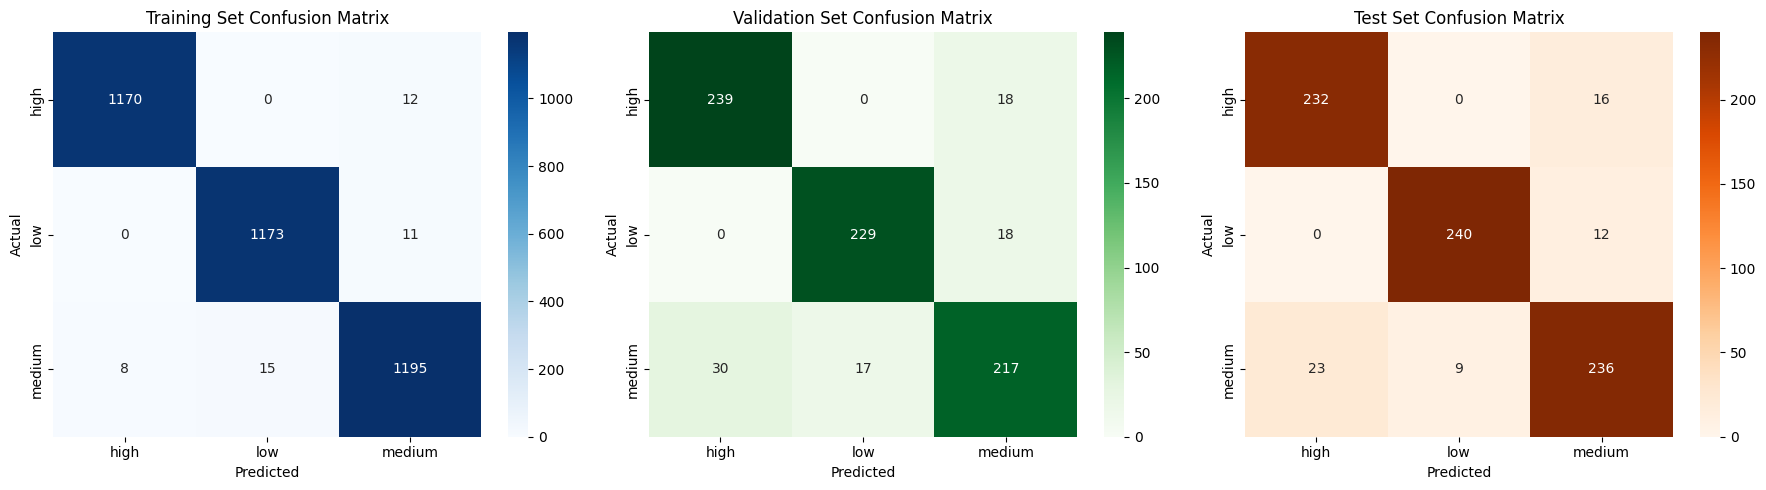

✓ Confusion matrices plotted successfully!

Step 10: Plotting training curves...


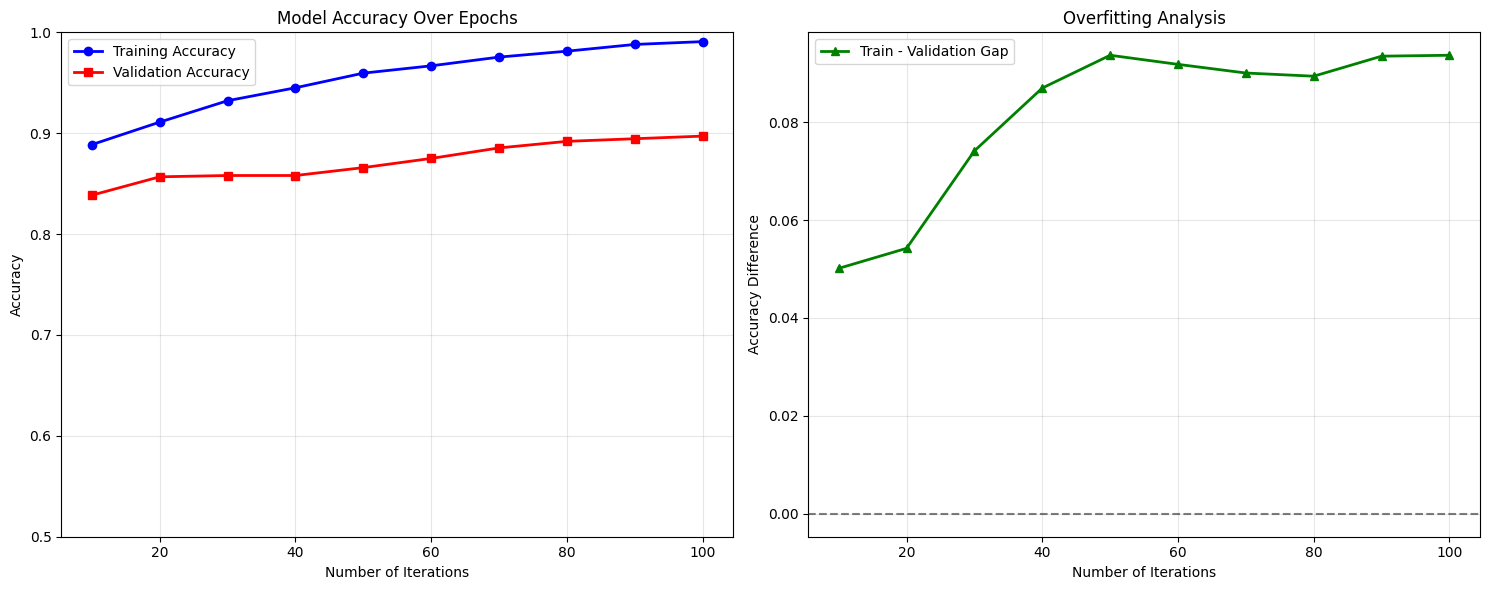

✓ Training curves plotted successfully!

Step 11: Creating results summary table...

FINAL RESULTS SUMMARY
              Metric  Training  Validation   Test
            Accuracy    0.9872      0.8919 0.9219
Precision (Weighted)    0.9872      0.8915 0.9220
   Recall (Weighted)    0.9872      0.8919 0.9219
 F1-Score (Weighted)    0.9872      0.8914 0.9219
      Macro F1-Score    0.9872      0.8924 0.9226

🏆 BEST PERFORMANCES:
Best Test Accuracy: 0.9219
Best Test Macro F1: 0.9226

Step 12: Analyzing feature importance...
❌ Model doesn't support feature importance

🎉 ALL STEPS COMPLETED SUCCESSFULLY!
📊 Model trained and evaluated on 83 features
🎯 Final Test Macro F1-Score: 0.9226

✅ Analysis completed successfully!
📈 Results stored in 'results' dictionary


In [22]:

# Step 14: Execute the Complete Pipeline
# ============================================================================
if __name__ == "__main__":
    # Run the complete analysis
    results = main()

    if results:
        print(f"\n✅ Analysis completed successfully!")
        print(f"📈 Results stored in 'results' dictionary")
    else:
        print(f"\n❌ Analysis failed. Please check the error messages above.")